<a href="https://colab.research.google.com/github/rennyatwork/CegepSteFoy_IA/blob/main/08_deep_learning/TransferLearningRadioCommands.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nous allons utiliser le transfer learning pour entrainer le classificateur de bouttons de radio (à partir du jeu de données RadioCommandsData.csv) en ré-utilisant le modèle pré-entrainé VGG-16, et ainsi démontrer que le transfer learning peut parfois avoir des capacité limité avec des formes, dessins, oeuvres d'art, etc. (qui ne sont pas des images standards).

1. Importation des packages utiles

In [1]:
import numpy as np
from numpy import asarray
from numpy import unique
from numpy import argmax
from numpy import sqrt
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import tensorflow_datasets as tfds

2. Importation des données

In [2]:
df = read_csv('https://raw.githubusercontent.com/rennyatwork/CegepSteFoy_IA/main/08_deep_learning/data/RadioCommandsData.csv')
print(len(df))
df.head(10)

330


,ID,Label,CenterX,CenterY,Height,Width,X1,X2,X3,X4,...,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64
0,1,0,0.142857,0.214286,0.428571,0.285714,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0.285714,0.214286,0.428571,0.285714,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0.428571,0.214286,0.428571,0.285714,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0.571429,0.214286,0.428571,0.285714,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0.714286,0.214286,0.428571,0.285714,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6,0,0.857143,0.214286,0.428571,0.285714,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0.142857,0.357143,0.428571,0.285714,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,8,0,0.285714,0.357143,0.428571,0.285714,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,9,0,0.428571,0.357143,0.428571,0.285714,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10,0,0.571429,0.357143,0.428571,0.285714,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


3. Reformatter les X en images

In [3]:
X_flat = np.array(df)
X_flat = X_flat[:,6:]
X_flat = X_flat.astype(np.float32)

X_complete = np.reshape(X_flat,(330,8,8,1))
X_complete[0]

array([[[1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]], dtype=float32)

4. Dupliquer les entrées 3 fois pour émuler un R (red) / G (green) / Blue (blue)

In [4]:
X_complete_3d = np.repeat(np.expand_dims(X_complete, axis=3), 3, axis=3)
X_complete_3d[0]
print(X_complete_3d.shape)

(330, 8, 8, 3, 1)


5. Extraire les variables y (partie catégorique uniquement)

In [5]:
y_complete = np.array(df)[:,1]
y_complete[0:3]

array([0., 0., 0.])

6. Diviser les données en train et test data

In [7]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X_complete_3d, y_complete, test_size=0.33)
print(X_train_full.shape, X_test.shape, y_train_full.shape, y_test.shape) #Validation sur les données dans chaque jeu de données résultants

(221, 8, 8, 3, 1) (109, 8, 8, 3, 1) (221,) (109,)


7. Conserver une partie des données en validation

In [8]:
X_train, y_train = X_train_full[:-50], y_train_full[:-50]
X_valid, y_valid = X_train_full[-50:], y_train_full[-50:]
print(X_train_full.shape, X_test.shape,X_train.shape,X_valid.shape, y_train_full.shape, y_test.shape,y_train.shape,y_valid.shape)

(221, 8, 8, 3, 1) (109, 8, 8, 3, 1) (171, 8, 8, 3, 1) (50, 8, 8, 3, 1) (221,) (109,) (171,) (50,)


8. Modifier la "shape" des données pour se conformer aux entrées attendus de Keras et storer la shape des images d'input dans une variable nommée in_shape (pour le première couche d'entrée)

In [9]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 3))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 3))
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], X_valid.shape[2], 3))

in_shape = X_train.shape[1:]
print(in_shape)

(8, 8, 3)


9. Visualiser quelques images

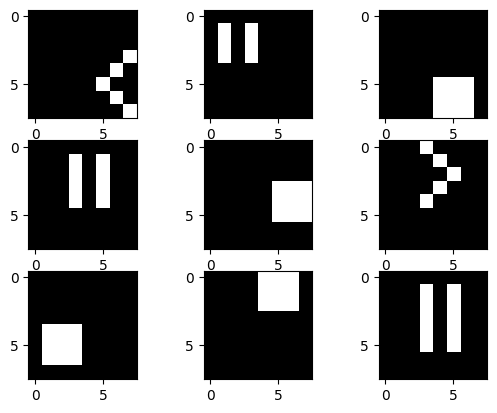

In [10]:
from matplotlib import pyplot
for i in range(9):
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

10. Storer le nombre de clasees possibles (5 dans ce cas-ci, car 0, 1, 2, 3, 4) dans la variable n_classes

In [11]:
n_classes = len(unique(y_train))
print(n_classes)

5


11. Pré-processing #1: adaptater les images au format requis par le modèle VGG-16: dans le cas de VGG-16, les images doivent être de taille 150 x 150

In [12]:
X_train = tf.image.resize(X_train, (150,150))
X_test = tf.image.resize(X_test, (150,150))
X_valid = tf.image.resize(X_valid, (150,150))

print(X_train.shape, X_test.shape, X_valid.shape)

(171, 150, 150, 3) (109, 150, 150, 3) (50, 150, 150, 3)


12. Re-visualiser quelques images après le pré-processing #1

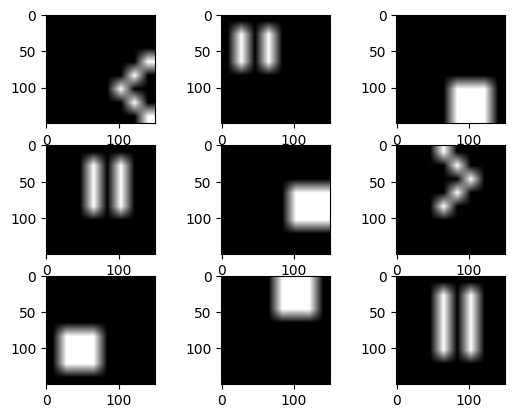

In [13]:
from matplotlib import pyplot
for i in range(9):
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

13. Pré-processing #2: importer VGG-16 ainsi que son application de pré-processing des inputs

In [14]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)
X_valid = preprocess_input(X_valid)

print(X_train.shape, X_test.shape, X_valid.shape)

(171, 150, 150, 3) (109, 150, 150, 3) (50, 150, 150, 3)


14. Définition du modèle via l'API Functionnal de Keras, le tout en utilisant le modèle VGG-16 (sans le top, c'est-à-dire sans la dernière couche, car nous allons remplacer cette dernière couche par nos propres couches (GlobalAveragePooling2D, dense et SoftMax en output))

In [15]:
base_model = VGG16(weights="imagenet", include_top=False)

avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

dense = tf.keras.layers.Dense(10, activation='relu', kernel_initializer='he_uniform')(avg)

output = tf.keras.layers.Dense(n_classes,activation="softmax")(dense)

model = tf.keras.Model(inputs = base_model.input, outputs=output)

58889256/58889256 [==============================] - 0s 0us/step


15. Pour commencer, nous n'allons pas ré-entrainer les poids et biais de VGG-16 (nous allons commencer par uniquement entrainer les poids de notre Softmax final)

In [16]:
for layer in base_model.layers:
  layer.trainable=False

16. Compiler le modèle

In [17]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)

model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,metrics=["accuracy"])

17. Entrainer le modèle

In [18]:
history = model.fit(X_train, y_train, batch_size=32 , validation_data=(X_valid,y_valid),epochs=5)

Epoch 1/5
6/6 [==============================] - 15s 852ms/step - loss: 26.2510 - accuracy: 0.2222 - val_loss: 1.5762 - val_accuracy: 0.3600
Epoch 2/5
6/6 [==============================] - 0s 84ms/step - loss: 1.5597 - accuracy: 0.3743 - val_loss: 1.5172 - val_accuracy: 0.3600
Epoch 3/5
6/6 [==============================] - 0s 88ms/step - loss: 1.5025 - accuracy: 0.3743 - val_loss: 1.5006 - val_accuracy: 0.3600
Epoch 4/5
6/6 [==============================] - 0s 82ms/step - loss: 1.4980 - accuracy: 0.3743 - val_loss: 1.5089 - val_accuracy: 0.3600
Epoch 5/5
6/6 [==============================] - 1s 89ms/step - loss: 1.5024 - accuracy: 0.3743 - val_loss: 1.5078 - val_accuracy: 0.3600


18. Évaluation de l'ajustement du modèle (avec les métriques classiques: loss, accuracy)

In [19]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Accuracy: 0.349


19. Si on atteint un plateau d'accuracy en entrainant seulement la dernière couche, c'est souvent signe qu'on peut commencer à entrainer aussi quelques couches du réseau pré-entrainer en les débloquant, par exemple, ici on débloque toutes les couches à partir de la 1ère

In [20]:
for layer in base_model.layers[10:]:
  layer.trainable=True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,metrics=["accuracy"])

history = model.fit(X_train,y_train,batch_size=32 , validation_data=(X_valid,y_valid),epochs=5)

Epoch 1/5
6/6 [==============================] - 5s 225ms/step - loss: 1.4998 - accuracy: 0.3743 - val_loss: 1.5074 - val_accuracy: 0.3600
Epoch 2/5
6/6 [==============================] - 1s 122ms/step - loss: 1.4992 - accuracy: 0.3743 - val_loss: 1.5067 - val_accuracy: 0.3600
Epoch 3/5
6/6 [==============================] - 1s 114ms/step - loss: 1.4989 - accuracy: 0.3743 - val_loss: 1.5058 - val_accuracy: 0.3600
Epoch 4/5
6/6 [==============================] - 1s 121ms/step - loss: 1.4977 - accuracy: 0.3743 - val_loss: 1.5055 - val_accuracy: 0.3600
Epoch 5/5
6/6 [==============================] - 1s 117ms/step - loss: 1.4970 - accuracy: 0.3743 - val_loss: 1.5047 - val_accuracy: 0.3600


20. Ré-évaluation de la performance du modèle

In [21]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Accuracy: 0.349


21. Évaluation de l'ajustement du modèle (avec une matrice de confusion)

In [22]:
y_pred = argmax(model.predict(X_test),axis=1)
cm = confusion_matrix(y_test,y_pred)
cm

4/4 [==============================] - 0s 75ms/step


array([[38,  0,  0,  0,  0],
       [31,  0,  0,  0,  0],
       [ 8,  0,  0,  0,  0],
       [18,  0,  0,  0,  0],
       [14,  0,  0,  0,  0]])

In [32]:
def do_analysis_MaxPooling():
  base_model = VGG16(weights="imagenet", include_top=False)

  avg = tf.keras.layers.GlobalMaxPool2D()(base_model.output)

  dense = tf.keras.layers.Dense(10, activation='relu', kernel_initializer='he_uniform')(avg)

  output = tf.keras.layers.Dense(n_classes,activation="softmax")(dense)

  model = tf.keras.Model(inputs = base_model.input, outputs=output)

  for layer in base_model.layers:
    layer.trainable=False

  optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

  model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,metrics=["accuracy"])

  history = model.fit(X_train, y_train, batch_size=10 , validation_data=(X_valid,y_valid),epochs=20)

  loss, acc = model.evaluate(X_test, y_test, verbose=0)
  print('Accuracy: %.3f' % acc)

In [33]:
do_analysis_MaxPooling()

Epoch 1/20
18/18 [==============================] - 2s 77ms/step - loss: 2.1232 - accuracy: 0.2573 - val_loss: 1.5749 - val_accuracy: 0.3600
Epoch 2/20
18/18 [==============================] - 1s 36ms/step - loss: 1.5538 - accuracy: 0.3743 - val_loss: 1.5241 - val_accuracy: 0.3600
Epoch 3/20
18/18 [==============================] - 1s 37ms/step - loss: 1.5159 - accuracy: 0.3743 - val_loss: 1.5086 - val_accuracy: 0.3600
Epoch 4/20
18/18 [==============================] - 1s 36ms/step - loss: 1.5029 - accuracy: 0.3743 - val_loss: 1.5025 - val_accuracy: 0.3600
Epoch 5/20
18/18 [==============================] - 1s 36ms/step - loss: 1.5009 - accuracy: 0.3743 - val_loss: 1.5021 - val_accuracy: 0.3600
Epoch 6/20
18/18 [==============================] - 1s 37ms/step - loss: 1.4965 - accuracy: 0.3743 - val_loss: 1.4974 - val_accuracy: 0.3600
Epoch 7/20
18/18 [==============================] - 1s 36ms/step - loss: 1.4972 - accuracy: 0.3743 - val_loss: 1.4955 - val_accuracy: 0.3600
Epoch 8/20
18

In [28]:
base_model = VGG16(weights="imagenet", include_top=False)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     